## Pymultifracs:<br> python multifractal analysis toolbox

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", context='notebook')
figure_folder = 'figures/fBm/'

import numpy as np

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600

### Let's simulate a couple signals

In [3]:
from pymultifracs.simul import mrw, fbm

X_fbm = np.diff(fbm(shape=65536, H=0.8))
X_mrw = np.diff(mrw(shape=65536, H=0.8, lam=np.sqrt(0.03), L=65536))

In [4]:
def plot_signals(X_fbm, X_mrw):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7, 3))
    ax[0].plot(X_fbm / np.std(X_fbm))
    ax[0].set(ylabel='$X_{\mathrm{fbm}}$')
    ax[1].plot(X_mrw / np.std(X_mrw))
    ax[1].set(ylabel='$X_{\mathrm{mrw}}$', xlabel='t', xticks=[])

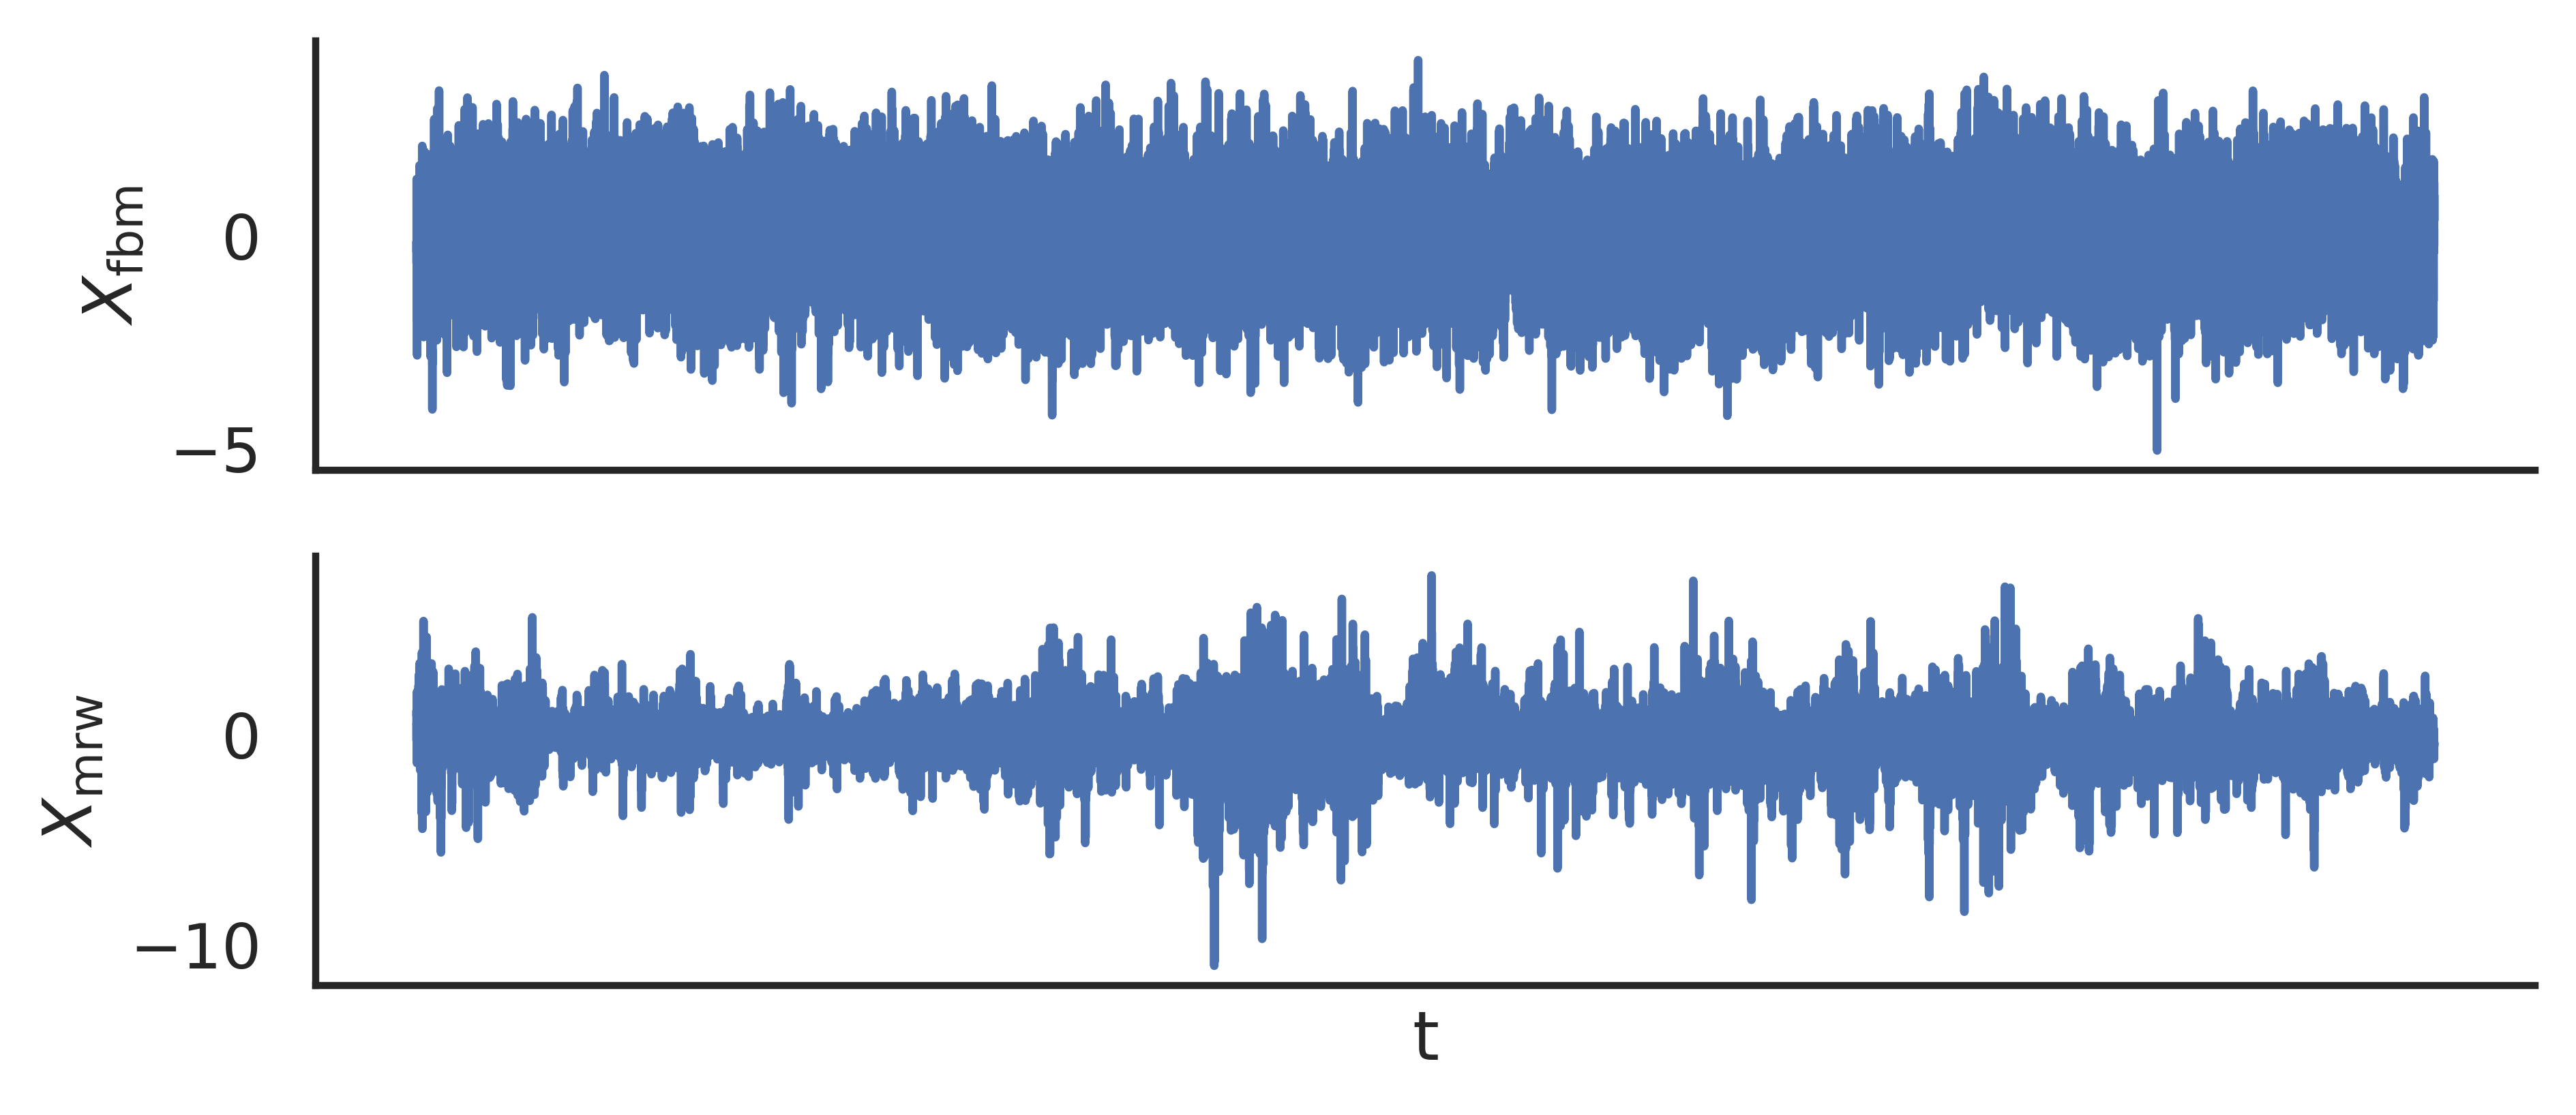

In [5]:
plot_signals(X_fbm, X_mrw)
sns.despine()

## Wavelet analysis

In [8]:
from pymultifracs.wavelet import wavelet_analysis

WT_fbm = wavelet_analysis(X_fbm, p_exp=2, wt_name='db3', j1=3, j2_reg=12, gamint=1)
WT_mrw = wavelet_analysis(X_mrw, p_exp=2, wt_name='db3', j1=3, j2_reg=12, gamint=1)

WT_fbm.eta_p, WT_mrw.eta_p

(array([1.55079168]), array([1.61913295]))

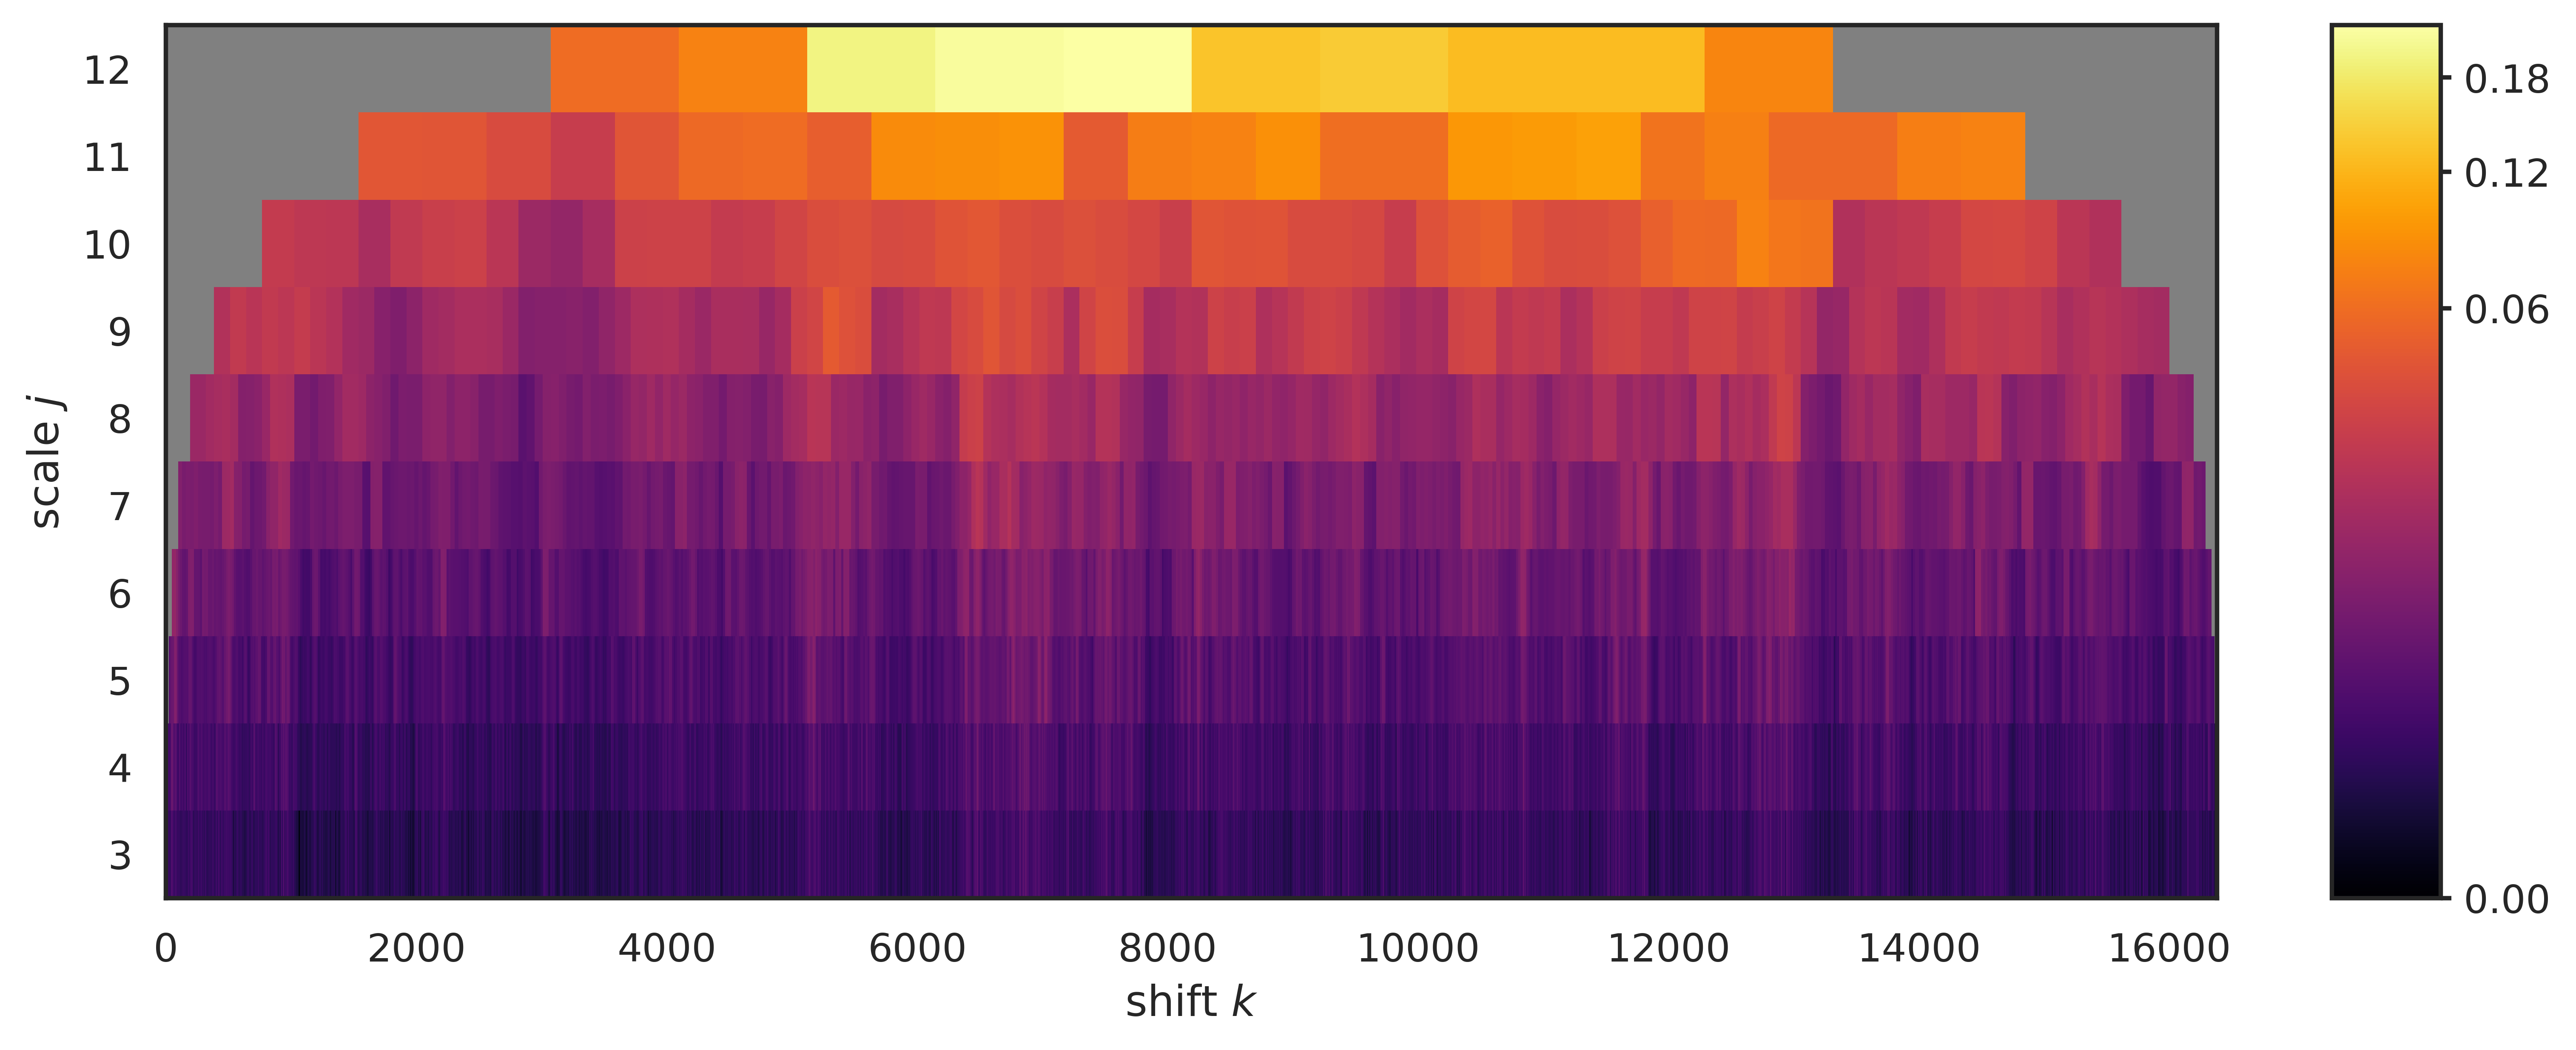

In [9]:
from pymultifracs.viz import plot_coef

plot_coef(WT_mrw.wt_leaders.values, j1=3, j2=12, figsize=(10, 4))

## Multifractal analysis

## Utility functions

## MEG DATA